## Day-of-Week Historical Average (HA)

In [13]:
import matplotlib.pyplot as plt
from datetime import datetime
import gzip
import pickle
import os
import matplotlib
%matplotlib inline
from pylab import rcParams
import pandas as pd
import pystan
from matplotlib.ticker import MultipleLocator
from scipy.stats import gaussian_kde
import numpy as np
from datetime import datetime, timedelta
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

rcParams['figure.figsize'] = 16, 14

In [ ]:
def plot_quarterly(model_name, mean_predictions, ci_95_half_widths, y_test_2014):
    def add_date_index(values):
        return pd.Series(values, 
                         index=pd.date_range(start=datetime(2014, 1, 1), end=datetime(2014, 12, 30)))
    
    def filter_date_range(series):
        return series\
            [lambda df: df.index >= from_date_inclusive]\
            [lambda df: df.index < to_date_non_inclusive]
    
    plt.tight_layout()
    for i, (quarter, from_date_inclusive, to_date_non_inclusive) in enumerate([
        ('Q1', datetime(2014, 1, 1), datetime(2014, 4, 1)),
        ('Q2', datetime(2014, 4, 1), datetime(2014, 7, 1)),
        ('Q3', datetime(2014, 7, 1), datetime(2014, 10, 1)),
        ('Q4', datetime(2014, 10, 1), datetime(2014, 12, 31))
    ]):    
        plt.subplot(411 + i)
        plt.plot(filter_date_range(y_test_2014), "b-", label='Actual', lw=1.5)
        plt.plot(filter_date_range(mean_predictions), "r-x", label='Predicted', lw=1)
        plt.fill_between(filter_date_range(y_test_2014).index, 
                         filter_date_range(mean_predictions + ci_95_half_widths),
                         filter_date_range(mean_predictions - ci_95_half_widths),
                         color='lightgrey', label='95% C.I.')
        plt.legend(loc='lower left', fontsize=12)
        plt.text(0.01, 0.9, quarter, fontsize=20,
                 horizontalalignment='left', verticalalignment='center', transform=plt.gca().transAxes)
        if i == 0:
            plt.title(model_name, fontsize=20)


In [2]:
# Dataframe
births_2000s_df = pd.read_csv('US_births_2000-2014_SSA.csv')
births_2000s_df_with_index = births_2000s_df\
    .rename(columns={'date_of_month': 'day'})\
    .set_index(pd.to_datetime(
        births_2000s_df.rename(columns={'date_of_month': 'day'})
        [['year', 'month', 'day']]))\
    .assign(weekday_name=lambda df: df.index.weekday_name)\
    .assign(day_of_year=lambda df: df.index.dayofyear)\
    .assign(week_of_year=lambda df: df.index.weekofyear)
births_2000s_df_with_index.tail()

,year,month,day,day_of_week,births,weekday_name,day_of_year,week_of_year
2014-12-27,2014,12,27,6,8656,Saturday,361,52
2014-12-28,2014,12,28,7,7724,Sunday,362,52
2014-12-29,2014,12,29,1,12811,Monday,363,1
2014-12-30,2014,12,30,2,13634,Tuesday,364,1
2014-12-31,2014,12,31,3,11990,Wednesday,365,1


In [3]:
def get_train_and_test_for_sliding_window(test_date):
    num_data_points_before_first_test_date = datetime(2014, 1, 1) - datetime(2001, 1, 1)
    df = births_2000s_df_with_index[['day_of_week', 'births']]\
        [lambda df: df.index <= test_date + timedelta(days=6)]\
        [lambda df: df.index >= test_date - num_data_points_before_first_test_date]
    return {
        'x_train': df.day_of_week[:-7].values,
        'y_train': df.births[:-7].values,
        'x_test': df.day_of_week[-7:].values,
        'y_test': df.births[-7:].values
    }
        
get_train_and_test_for_sliding_window(datetime(2014, 1, 1))

{'x_test': array([3, 4, 5, 6, 7, 1, 2], dtype=int64),
 'x_train': array([1, 2, 3, ..., 7, 1, 2], dtype=int64),
 'y_test': array([ 8018, 11171, 12317,  8199,  7174, 11400, 12310], dtype=int64),
 'y_train': array([ 7663, 10635, 12449, ...,  7896, 13096, 12525], dtype=int64)}

In [4]:
def historical_average(x_train, y_train):
    ha = np.empty(7)
    ci_95_half_width = np.empty(7)
    for i in range(7):
        ha[i] = y_train[x_train - 1 == i].mean()
        ci_95_half_width[i] = 1.96 * y_train[x_train - 1 == i].std() / np.sqrt(sum(x_train - 1 == i))
    return ha, ci_95_half_width

In [5]:
# Quick check for one window.
historical_average(
    get_train_and_test_for_sliding_window(datetime(2014, 1, 1))['x_train'],
    get_train_and_test_for_sliding_window(datetime(2014, 1, 1))['y_train'])

(array([11929.12223859, 13172.18409426, 12974.72418879, 12905.24483776,
        12638.68141593,  8539.78318584,  7488.92182891]),
 array([89.4599121 , 69.79938226, 67.25094379, 89.0243478 , 75.93481567,
        37.4211567 , 29.10729863]))

In [6]:
def rmse(prediction_errors):
    return (prediction_errors ** 2).mean() ** 0.5

In [7]:
def fit_ha_sliding_windows(num_windows):
    predictions = []
    ci_95_half_widths = []
    y_test_2014 = []
    for i in range(num_windows):
        data = get_train_and_test_for_sliding_window(datetime(2014, 1, 1) + timedelta(days=i * 7))
        y_test_2014.extend(data['y_test'])
        y_pred, ci_95_hw = [values[data['x_test'] - 1] for values in 
                            historical_average(data['x_train'], data['y_train'])]
        predictions.extend(y_pred)
        ci_95_half_widths.extend(ci_95_hw)
    return [pd.Series(
        values, 
        index=pd.date_range(start=datetime(2014, 1, 1), end=datetime(2014, 12, 30))) 
            for values in (predictions, ci_95_half_widths, y_test_2014)]

In [8]:
predicitons, ci_95_half_widths, y_test_2014 = fit_ha_sliding_windows(num_windows=52)

In [9]:
rmse(predicitons - y_test_2014)

896.5599217481686

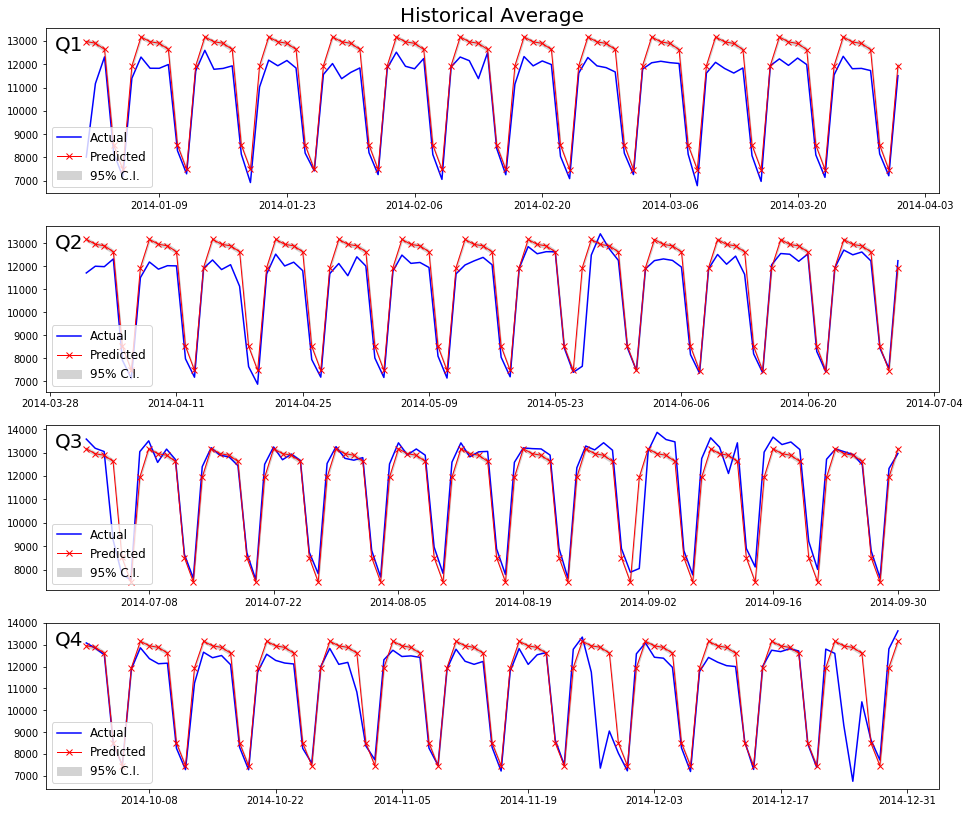

In [14]:
plot_quarterly('Historical Average', predicitons, ci_95_half_widths, y_test_2014)